In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import os
import pandas as pd
import seaborn as sns
import pytraj as pt
import mdtraj as mdt
from pathlib import Path
import json
from pytraj import matrix

path='/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement'
os.chdir(path)
print(os.getcwd())


/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement


In [2]:
#Python
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.teaching import *
from pyrosetta.toolbox import *

#Core Includes
#from rosetta.core.kinematics import MoveMap
from pyrosetta.rosetta.core.kinematics import FoldTree
from rosetta.core.pack.task import TaskFactory
from rosetta.core.pack.task import operation
from rosetta.core.simple_metrics import metrics
from rosetta.core.select import residue_selector as selections
from rosetta.core import select
from rosetta.core.select.movemap import *

#Protocol Includes
from rosetta.protocols import minimization_packing as pack_min
from rosetta.protocols import relax as rel
from rosetta.protocols.antibody.residue_selector import CDRResidueSelector
from rosetta.protocols.antibody import *
from rosetta.protocols.loops import *
from rosetta.protocols.relax import FastRelax
from pyrosetta.rosetta.core.scoring import get_score_function, rama_prepro

init('-use_input_sc -input_ab_scheme AHo_Scheme -ignore_unrecognized_res \
     -ignore_zero_occupancy false -load_PDB_components false -relax:default_repeats 2 -no_fconfig -mute all')

#WRITE FUNCTION FOR MUTATION
import pyrosetta
from pyrosetta import pose_from_pdb, get_score_function
import os
import random

def pack(pose, posi, amino, scorefxn):

    #Set Reference Pose
    RMSD_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric(relaxPose)
    
    
    # Select Mutate Position
    mut_posi = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector()
    mut_posi.set_index(posi)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(mut_posi.apply(pose)))

    # Select Neighbor Position
    nbr_selector = pyrosetta.rosetta.core.select.residue_selector.NeighborhoodResidueSelector()
    nbr_selector.set_focus_selector(mut_posi)
    nbr_selector.set_include_focus_in_subset(True)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(nbr_selector.apply(pose)))
    
    # Select No Design Area
    not_design = pyrosetta.rosetta.core.select.residue_selector.NotResidueSelector(mut_posi)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(not_design.apply(pose)))

    # The task factory accepts all the task operations
    tf = pyrosetta.rosetta.core.pack.task.TaskFactory()

    # These are pretty standard
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.InitializeFromCommandline())
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.IncludeCurrent())
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.NoRepackDisulfides())

    # Disable Packing
    prevent_repacking_rlt = pyrosetta.rosetta.core.pack.task.operation.PreventRepackingRLT()
    #True indicates here that we are flipping the selection.  So that we are turning off everything but the CDR and its neighbors.
    prevent_subset_repacking = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(prevent_repacking_rlt, nbr_selector, True )
    tf.push_back(prevent_subset_repacking)

    # Disable design
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(
        pyrosetta.rosetta.core.pack.task.operation.RestrictToRepackingRLT(),not_design))

    # Enable design
    aa_to_design = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASRLT()
    aa_to_design.aas_to_keep(amino)
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(aa_to_design, mut_posi))
    
    # Create Packer
    packer = pyrosetta.rosetta.protocols.minimization_packing.PackRotamersMover()
    packer.task_factory(tf)
    print(tf.create_task_and_apply_taskoperations(pose))


    
    #Perform The Move
    if not os.getenv("DEBUG"):
      packer.apply(pose)

print('\nCheckpoint')

┌───────────────────────────────────────────────────────────────────────────────┐
│                                  PyRosetta-4                                  │
│               Created in JHU by Sergey Lyskov and PyRosetta Team              │
│               (C) Copyright Rosetta Commons Member Institutions               │
│                                                                               │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRES PURCHASE OF A LICENSE │
│          See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└───────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2025 [Rosetta PyRosetta4.Release.python310.mac 2025.39+release.c389ea27189ed431c5f30718cf7d86843feeab8e 2025-09-24T10:26:10] retrieved from: http://www.pyrosetta.org

Checkpoint


/var/folders/tp/lkm8lbb14gb6_ysd0kvxpkgm0000gn/T/ipykernel_1499/325628446.py:10: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.core.pack.task import TaskFactory


In [3]:
#FULL FEATURE COLLECTION LETS GO
path='/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement'
os.chdir(path)
#print(os.getcwd())
mut=['1rwy_WT','1rwy_s78r','1rwy_e81a','1rwy_e59d','1rwy_l85f','1rwy_s55d_e59d','1rwy_d94s_g98d', \
     '1g33_WT','1g33_s78r','1g33_e81a','1g33_e59d','1g33_l85f','1g33_s55d_e59d','1g33_d94s_g98d']
#mut= ['1g33_e59d']
replicates=['1','2','3','4','5']




import numpy as np
import pandas as pd

# Prepare an empty list to hold all replicate results
all_features = []

for protein in mut:
    full_path=  path + '/' + protein
    #print(full_path)
    os.chdir(full_path)
    for rep in replicates:
        print(protein)
        try:
            if protein[:4] == '1rwy':
                trajectory = protein + '_ProtIon_rep' + rep + '.dcd'
                topology = protein + '_ProtIon.pdb'
            else:
                trajectory = protein + '_ProtIon_rep' + rep + '.nc'
                topology = protein + '_ProtIon.prmtop'
            
            # Attempt to load trajectory
            traj = pt.load(trajectory, top=topology)
            
            # Continue with your processing here...
            print(f"Loaded {trajectory} successfully")
        
        except ValueError:
            print(f"Replicate {rep} for {protein} missing or invalid, skipping...")
            continue
        #Calculate RMSF for each replicate of each system
        traj_imposed= pt.superpose(traj,ref=0)
    
        
        #RMSF
        
        rmsf_data=pt.rmsf(traj_imposed,mask='@CA',options='byres')
        #print(WTrmsf_data1.T[0])
        arrays = [np.array(x) for x in rmsf_data]
        rmsf_mean=[np.mean(k) for k in zip(*arrays)]
        rmsf_std=[np.std(k) for k in zip(*arrays)]
        #print(rmsf_data)
        #print(len(rmsf_mean))
        rmsf_mean=rmsf_mean[1]
        rmsf_std=rmsf_std[1]
        print(rmsf_mean)
        print(rmsf_std)
        
        if protein=='1g33_WT' or protein=='1g33_s78r' or protein=='1g33_e81a':
            rmsf_data.T[0]=rmsf_data.T[0]+36
        #print(rmsf_data.T[1][70:])
        
        #RMSD
        rmsd_data=pt.rmsd(traj, mask='@CA')
        #print(rmsd_data)
        #print(len(rmsd_data))
        rmsd_mean=np.mean(rmsd_data)
        print(rmsd_mean)
        rmsd_std=np.std(rmsd_data)
        print(rmsd_std)
     

        #RoG
        rog_data=pt.radgyr(traj, mask='@CA')
        rog_mean=np.mean(rog_data)
        print(rog_mean)
        rog_std=np.std(rog_data)
        print(rog_std)
    
        #DSSP

        if protein[:4]=='1rwy':
            residues, ss, avg = pt.dssp(traj, ":37-109")
        else:
            residues, ss, avg = pt.dssp(traj, ":1-73")

        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        #print(ss)
        first = ss[0].tolist()
        last = ss[-1].tolist()
        none=np.mean(avg[0])
        extended=np.mean(avg[1])
        bridge=np.mean(avg[2])
        three_ten_helix=np.mean(avg[3])
        alpha_helix=np.mean(avg[4])
        pi=np.mean(avg[5])
        turn=np.mean(avg[6])
        bend=np.mean(avg[7])
        total= none+extended+bridge+three_ten_helix+alpha_helix+pi+turn+bend
        #print(total)
        #print(str(none) + ' \n' + str(extended) + '\n'  + str(bridge) + '\n' 
        #        + str(three_ten_helix) + '\n' + str(alpha_helix) + '\n' + str(pi) + '\n' 
        #        + str(turn) + '\n' + str(bend))
        print(alpha_helix)
        print(extended) #parallel beta-sheet
        print(bridge) #anti-parallel beta-sheet

        #DSSP alpha-helical character of CD site(s)
        
        if protein[:4]=='1rwy':
            residues, ss, avg = pt.dssp(traj, ":59-70")
        else:
            residues, ss, avg = pt.dssp(traj, ":23-34")

        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        first = ss[0].tolist()
        last = ss[-1].tolist()
        D_none=np.mean(avg[0])
        D_extended=np.mean(avg[1])
        D_bridge=np.mean(avg[2])
        D_three_ten_helix=np.mean(avg[3])
        D_alpha_helix=np.mean(avg[4])
        D_pi=np.mean(avg[5])
        D_turn=np.mean(avg[6])
        D_bend=np.mean(avg[7])

        #DSSP alpha-helical character of EF-site(s)
        if protein[:4]=='1rwy':
            residues, ss, avg = pt.dssp(traj, ":78-:90")
        else:
            residues, ss, avg = pt.dssp(traj, ":42-54")

        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        first = ss[0].tolist()
        last = ss[-1].tolist()
        E_none=np.mean(avg[0])
        E_extended=np.mean(avg[1])
        E_bridge=np.mean(avg[2])
        E_three_ten_helix=np.mean(avg[3])
        E_alpha_helix=np.mean(avg[4])
        E_pi=np.mean(avg[5])
        E_turn=np.mean(avg[6])
        E_bend=np.mean(avg[7])

        if protein[:4]=='1rwy':
            residues, ss, avg = pt.dssp(traj, ":57-58")
        else:
            residues, ss, avg = pt.dssp(traj, ":21-22")

        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        first = ss[0].tolist()
        last = ss[-1].tolist()
        D_extended=np.mean(avg[1])

        if protein[:4]=='1rwy':
            residues, ss, avg = pt.dssp(traj, ":97-98")
        else:
            residues, ss, avg = pt.dssp(traj, ":61-62")

        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        first = ss[0].tolist()
        last = ss[-1].tolist()
        F_extended=np.mean(avg[1])

        #PyRosetta ENERGY
        if protein[:4]=='1rwy':
            pdb_file=topology
        else:
            pdb_file=protein+'_ProtIon.pdb'

        original = pose_from_pdb(pdb_file)
        print(protein)
        pose = original.clone()  # optional clone to avoid modifying original
        if protein[:4]=='1rwy':
            pose.delete_residue_range_slow(110, pose.total_residue())
        #print(pose.sequence())
        sequence=pose.sequence()
        #Clone it
        
        scorefxn = create_score_function("ref2015")
        scorefxn.set_weight(rama_prepro, 0.0)
        
        #print("Energy:", scorefxn(original),"\n")
        #print(scorefxn(pose))
        total_energy=scorefxn(pose)
        print(total_energy)
        #print('\n')


        #COMPILE IT ALL TOGETHER INTO A CSV

        row = {
        "System": protein,
        "Sequence": sequence,
        "RMSF_mean": rmsf_mean,
        "RMSF_std": rmsf_std,
        "RMSD_mean": rmsd_mean,
        "RMSD_std": rmsd_std,
        "RoG_mean": rog_mean,
        "RoG_std": rog_std,
        "a-helix": alpha_helix,
        "parallel beta-sheet": extended,
        "antiparallel beta-sheet": bridge,
        "D a-helix": D_alpha_helix,
        "D beta-sheet": D_extended,
        "E a-helix": E_alpha_helix,
        "F beta-sheet": F_extended,
        "Energy": total_energy
        }

        all_features.append(row)


path='/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement'
os.chdir(path)
df = pd.DataFrame(all_features)
df.to_csv("PV_features_with_std.csv", index=False)

print(df.tail())

1rwy_WT
Loaded 1rwy_WT_ProtIon_rep1.dcd successfully
0.47109831014218534
0.11275845792062439
0.6617446248293193
0.09441504337313394
12.59434866890969
0.037763267332101585
0.53688097
0.058587987
0.0044257115
1rwy_WT
-92.01173034222866
1rwy_WT
Loaded 1rwy_WT_ProtIon_rep2.dcd successfully
0.5276652201756975
0.13522880411788374
0.7475476206908753
0.10307515464772674
12.58876522871638
0.04715849898930046
0.55040663
0.05458048
0.002354452
1rwy_WT
-92.01173034222866
1rwy_WT
Loaded 1rwy_WT_ProtIon_rep3.dcd successfully
0.49875105373319584
0.13000206769069816
0.6998496450660159
0.08271441257340457
12.596329816697974
0.0459466928200885
0.530084
0.056308176
0.0030273215
1rwy_WT
-92.01173034222866
1rwy_WT
Replicate 4 for 1rwy_WT missing or invalid, skipping...
1rwy_WT
Replicate 5 for 1rwy_WT missing or invalid, skipping...
1rwy_s78r
Loaded 1rwy_s78r_ProtIon_rep1.dcd successfully
0.5462274988120338
0.15312618748957815
0.8715786197537481
0.13870399739099715
12.613759831940794
0.04709064139074603
0.5

In [4]:
#LETS GET TO USING THE SVM
'''
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

path='/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement'
os.chdir(path)


# PREP FOR TRAIN/TEST
df = pd.read_csv("PV_features_with_std.csv")

X = df.drop(columns=["System","Sequence"])
y = df["Energy"]
#ABOVE THRESHHOLD TESTING

#try binary classifier using energy- check if it's better off or not

#how to use trained algorithm:
#pick a site, see how introducing variants (into maybe already mutated sites) could give you a more stable structure
#next steps:
#perform with energy bootstrapping
#do a dropout of Energy
#

le = LabelEncoder()
y_encoded = le.fit_transform(y)


# TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1, gamma='scale')) #linear instead?
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)


y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)


print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))



# RUN PERMUTATIONS FOR FEATURE IMPORTANCE
#should I just make this linear?

perm_result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": perm_result.importances_mean
}).sort_values(by="importance", ascending=False)

print("\nPermutation Determined Feature Importance:\n", feature_importance)


# PLOT IT

plt.figure(figsize=(10,6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel("Permutation Importance (Mean Accuracy Decrease)")
plt.ylabel("Feature")
plt.title("Feature Importance from SVM Permutation Test")
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()
'''

'\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler, LabelEncoder\nfrom sklearn.svm import SVC\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.metrics import classification_report, confusion_matrix, accuracy_score\nfrom sklearn.inspection import permutation_importance\n\npath=\'/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement\'\nos.chdir(path)\n\n\n# PREP FOR TRAIN/TEST\ndf = pd.read_csv("PV_features_with_std.csv")\n\nX = df.drop(columns=["System","Sequence"])\ny = df["Energy"]\n#ABOVE THRESHHOLD TESTING\n\n#try binary classifier using energy- check if it\'s better off or not\n\n#how to use trained algorithm:\n#pick a site, see how introducing variants (into maybe already mutated sites) could give you a more stable structure\n#next steps:\n#perform with energy bootstrapping\n#do a dropout of Energy\n#\n\nle = LabelEncoder()\ny_encoded = le.fit_transform(y)\n\n\n# TRAIN/TEST\

In [5]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

path = "/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement"
os.chdir(path)

df = pd.read_csv("PV_features_with_std.csv")

# If embeddings already exist, skip generating them
if os.path.exists("PV_embeddings.npy"):
    print("Embedding file detected. Loading embeddings from disk.")
    import numpy as np
    embeddings = np.load("PV_embeddings.npy")

else:
    print("No embedding file found. Generating ESM2 embeddings... this may take a few minutes.")

    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
    model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
    model.eval()  # inference mode

    def embed_sequence(seq):
        inputs = tokenizer(seq, return_tensors="pt", add_special_tokens=True)
        with torch.no_grad():
            outputs = model(**inputs)
            # mean-pooled embedding across residues
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        return embedding

    # Compute embeddings for each sequence
    embeddings = df["Sequence"].apply(embed_sequence).to_list()
    embeddings = np.vstack(embeddings)  # convert list of vectors into matrix

    # Save to disk
    np.save("PV_embeddings.npy", embeddings)
    print("Embeddings saved to PV_embeddings.npy")


Embedding file detected. Loading embeddings from disk.


In [6]:
# Add embeddings into the dataframe
embed_df = pd.DataFrame(embeddings)
embed_df.columns = [f"emb_{i}" for i in range(embed_df.shape[1])]
df = pd.concat([df, embed_df], axis=1)


In [7]:
df.head(20)

,System,Sequence,RMSF_mean,RMSF_std,RMSD_mean,RMSD_std,RoG_mean,RoG_std,a-helix,parallel beta-sheet,antiparallel beta-sheet,D a-helix,D beta-sheet,E alpha-helix,F beta-sheet,Energy,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198,emb_199,emb_200,emb_201,emb_202,emb_203,emb_204,emb_205,emb_206,emb_207,emb_208,emb_209,emb_210,emb_211,emb_212,emb_213,emb_214,emb_215,emb_216,emb_217,emb_218,emb_219,emb_220,emb_221,emb_222,emb_223,emb_224,emb_225,emb_226,emb_227,emb_228,emb_229,emb_230,emb_231,emb_232,emb_233,emb_234,emb_235,emb_236,emb_237,emb_238,emb_239,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256,emb_257,emb_258,emb_259,emb_260,emb_261,emb_262,emb_263,emb_264,emb_265,emb_266,emb_267,emb_268,emb_269,emb_270,emb_271,emb_272,emb_273,emb_274,emb_275,emb_276,emb_277,emb_278,emb_279,emb_280,emb_281,emb_282,emb_283,emb_284,emb_285,emb_286,emb_287,emb_288,emb_289,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,emb_300,emb_301,emb_302,emb_303,emb_304,emb_305,emb_306,emb_307,emb_308,emb_309,emb_310,emb_311,emb_312,emb_313,emb_314,emb_315,emb_316,emb_317,emb_318,emb_319
0,1rwy_WT,SMTDLLSAEDIKKAIGAFTAADSFDKKFFQMVGLKKKSADDVKKVF...,0.471098,0.112758,0.661745,0.094415,12.594349,0.037763,0.536881,0.058588,0.004426,0.585256,0.0,0.0,0.0,-92.011730,-0.319957,0.072629,0.059670,0.064791,0.223575,0.121831,0.120817,0.028767,-0.300424,0.003211,0.019828,0.188617,-0.113960,0.064893,0.036717,-0.025889,0.020380,-0.064843,-0.444625,0.282458,-0.302515,0.081911,-0.251159,-0.125962,-0.225365,0.200742,-0.030622,0.129147,-0.003244,0.176034,-0.036098,0.431401,0.209217,0.221733,0.111571,-0.309275,-0.074507,-0.211224,0.115186,0.365539,0.095984,0.306259,-0.198421,-0.163248,0.191290,0.124764,-0.328414,-0.124751,0.008322,-0.004674,0.016927,-0.252184,-0.039652,0.188594,0.005535,-0.060548,0.187199,-0.025133,0.520325,-0.024428,-0.094123,0.001890,-3.935927,-0.103155,0.085421,-0.053750,0.229297,-0.020217,0.010675,0.032726,0.050047,0.172583,-0.188259,0.060022,0.190451,-0.026285,0.182006,0.023204,0.038125,0.158633,-0.140406,-0.127156,-0.034076,-0.310075,0.222020,-0.142359,0.130042,-0.163603,-0.107861,0.472766,0.092291,-0.223081,0.113378,-0.144374,-0.333732,0.054108,-0.135478,0.017886,-0.017479,0.256619,0.223299,-0.145845,-0.212941,0.122417,-0.031264,0.220093,0.017862,0.009916,-0.186709,0.053381,-0.017713,-0.006340,-0.182928,-0.043478,0.179059,-0.031825,0.033175,0.217468,0.060387,0.112380,0.223105,0.217910,0.021963,-0.201892,0.057801,0.083751,-0.196


Best Parameters: {'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}

R2 Score: -0.18702445789957278
MSE: 1897608534759.295

Permutation Determined Feature Importance:
                     feature  importance
5                   RoG_std    0.001506
11            E alpha-helix    0.001416
4                  RoG_mean    0.001388
2                 RMSD_mean    0.001334
7       parallel beta-sheet    0.001089
1                  RMSF_std    0.001049
8   antiparallel beta-sheet    0.000945
3                  RMSD_std    0.000703
6                   a-helix    0.000542
0                 RMSF_mean    0.000393
9                 D a-helix    0.000155
10             D beta-sheet    0.000000
12             F beta-sheet    0.000000


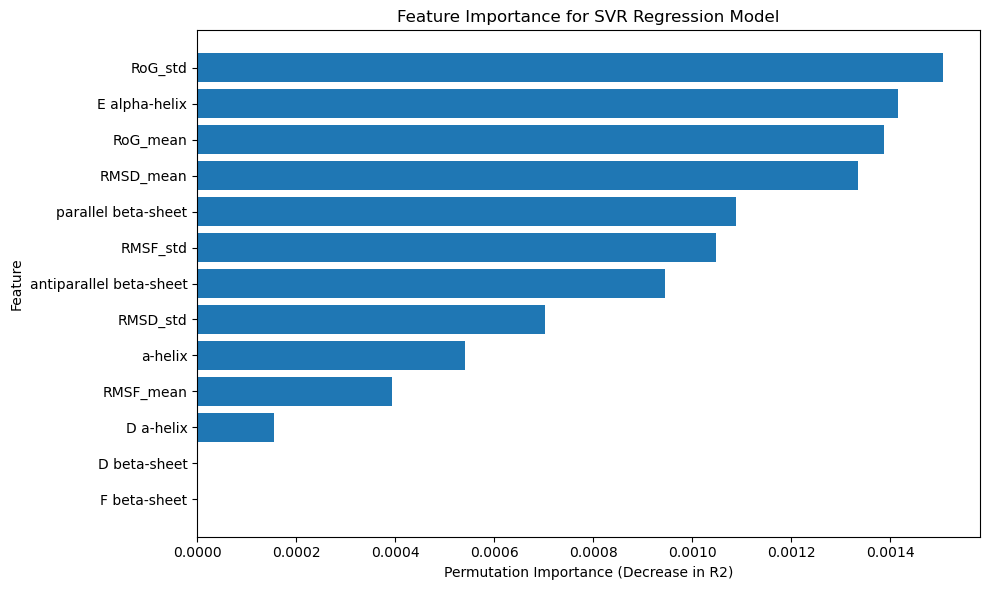

In [8]:
# Improved SVM Regression Pipeline for Predicting PyRosetta Energy

import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance


# LOAD DATA

path='/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement'
os.chdir(path)

df = pd.read_csv("PV_features_with_std.csv")

# Drop non-numeric/unusable columns
X = df.drop(columns=["System", "Sequence", "Energy"])
y = df["Energy"]

# Train/test split (no label encoding)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)





# PIPELINE WITH HYPERPARAMETER TUNING

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVR())
])

param_grid = {
    "svm__kernel": ["rbf", "linear"],
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.1, 0.01, 0.001]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="r2",
    cv=5,            # 5-fold cros-validation
    n_jobs=-1        # use all CPU cores
)

grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)

best_model = grid.best_estimator_





# EVALUATE PERFORMANCE

y_pred = best_model.predict(X_test)

print("\nR2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))





# PERMUTATION IMPORTANCE

perm = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean
}).sort_values(by="importance", ascending=False)

print("\nPermutation Determined Feature Importance:\n", feature_importance)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.xlabel("Permutation Importance (Decrease in R2)")
plt.ylabel("Feature")
plt.title("Feature Importance for SVR Regression Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Loading embeddings from disk...
R2 Score: 0.9998290313003853
MSE: 273315062.21851456

Permutation Feature Importance:
                      feature    importance
145                  emb_132  1.527002e-03
198                  emb_185  1.498304e-03
55                    emb_42  1.477982e-03
228                  emb_215  1.288869e-03
117                  emb_104  1.287699e-03
181                  emb_168  1.097229e-03
175                  emb_162  1.078514e-03
97                    emb_84  7.781154e-04
21                     emb_8  5.022875e-04
62                    emb_49  5.005426e-04
201                  emb_188  4.122136e-04
106                   emb_93  3.950442e-04
238                  emb_225  3.898668e-04
274                  emb_261  3.136108e-04
243                  emb_230  2.354009e-04
332                  emb_319  2.250398e-04
45                    emb_32  2.242437e-04
325                  emb_312  2.225117e-04
322                  emb_309  2.200624e-04
34                   

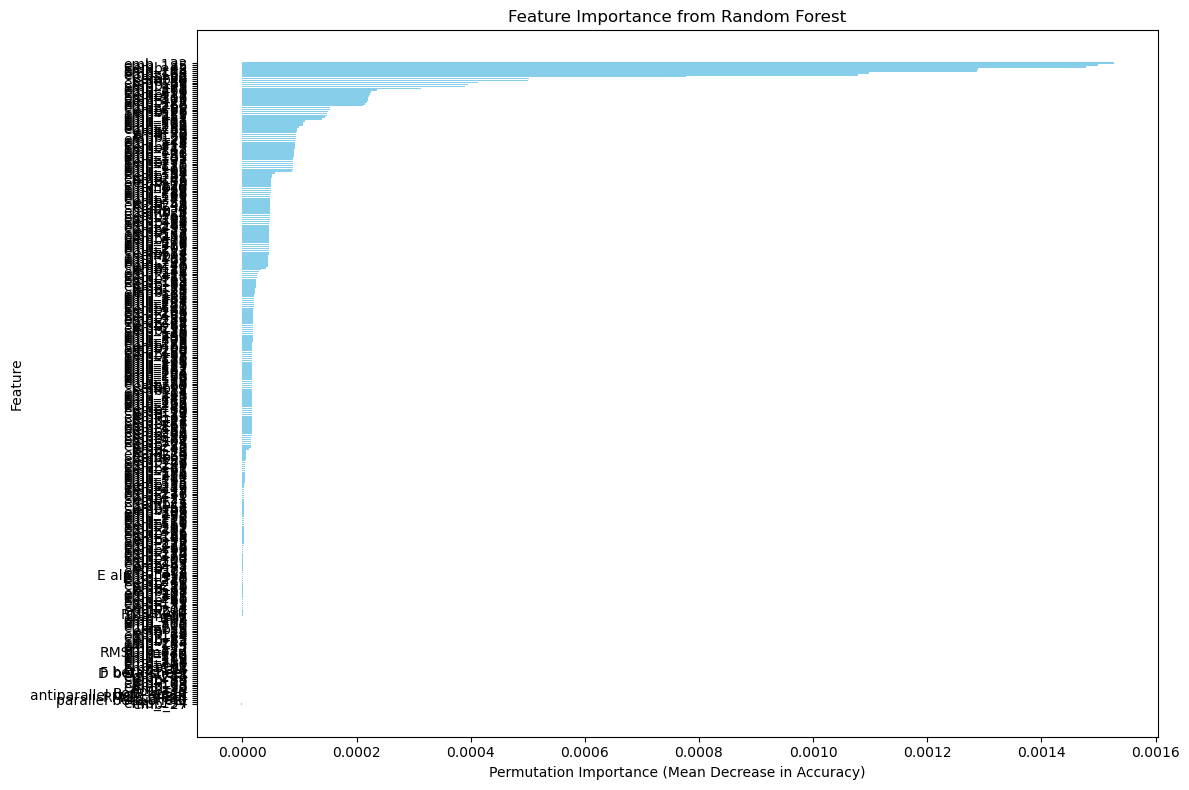

In [12]:
# PV Energy Prediction Using Random Forest + ESM2 Embeddings


import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import joblib



# Set working directory and load CSV

path = "/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement"
os.chdir(path)

df = pd.read_csv("PV_features_with_std.csv")




# Generate or load ESM2 embeddings

embedding_file = "PV_embeddings.npy"

if os.path.exists(embedding_file):
    print("Loading embeddings from disk...")
    embeddings = np.load(embedding_file)
else:
    print("Generating embeddings (ESM2)... this may take a while")
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
    model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
    model.eval()

    def embed_sequence(seq):
        inputs = tokenizer(seq, return_tensors="pt", add_special_tokens=True)
        with torch.no_grad():
            outputs = model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        return embedding

    embeddings = df["Sequence"].apply(embed_sequence).to_list()
    embeddings = np.vstack(embeddings)
    np.save(embedding_file, embeddings)
    print("Embeddings saved to", embedding_file)

# ------------------------------
# Add embeddings to dataframe
# ------------------------------
embed_df = pd.DataFrame(embeddings, columns=[f"emb_{i}" for i in range(embeddings.shape[1])])
df = pd.concat([df, embed_df], axis=1)

# ------------------------------
# (Optional) PCA on embeddings
# ------------------------------
do_pca = False  # Change to True to reduce embedding dimensionality

embed_cols = [col for col in df.columns if col.startswith("emb_")]
if do_pca:
    pca = PCA(n_components=50)  # reduce to 50 PCs
    embed_pca = pca.fit_transform(df[embed_cols])
    pca_df = pd.DataFrame(embed_pca, columns=[f"PC_{i}" for i in range(embed_pca.shape[1])])
    df = pd.concat([df.drop(columns=embed_cols), pca_df], axis=1)

# ------------------------------
# Prepare training data
# ------------------------------
X = df.drop(columns=["System", "Sequence", "Energy"])
y = df["Energy"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ------------------------------
# Standardize numeric features (optional for RF but helps for interpretability)
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# Train RandomForest Regressor
# ------------------------------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_scaled, y_train)

# ------------------------------
# Predictions and evaluation
# ------------------------------
y_pred = rf.predict(X_test_scaled)

from sklearn.metrics import r2_score, mean_squared_error

print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


joblib.dump(rf, "RF_energy_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# ------------------------------
# Permutation Feature Importance
# ------------------------------
perm = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean
}).sort_values(by="importance", ascending=False)

print("\nPermutation Feature Importance:\n", feature_importance)

# ------------------------------
# Plot Feature Importance
# ------------------------------
plt.figure(figsize=(12,8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel("Permutation Importance (Mean Decrease in Accuracy)")
plt.ylabel("Feature")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [13]:
joblib.dump(rf, "RF_energy_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import joblib
from Bio.PDB import PDBParser, MMCIFParser, PPBuilder
from sklearn.preprocessing import StandardScaler



# Load trained Random Forest and scaler

model_dir = "/Users/alecloftus/Desktop/PKHLAB/PV_Reengagement"
rf = joblib.load(os.path.join(model_dir, "RF_energy_model.pkl"))
scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))

# Load numeric feature columns used in training
df = pd.read_csv(os.path.join(model_dir, "PV_features_with_std.csv"))
numeric_cols = [col for col in df.columns if col not in ["System", "Sequence", "Energy"]]




# Load ESM2 model for embeddings

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model.eval()

def embed_sequence(seq):
    """Compute ESM2 embedding for a single sequence"""
    inputs = tokenizer(seq, return_tensors="pt", add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding




# Numeric features extraction (placeholder)

def extract_numeric_features(structure):
    """Extract numeric features (replace placeholders with your actual calculations)"""
    features = {}
    atoms = list(structure.get_atoms())
    coords = np.array([atom.get_coord() for atom in atoms])
    center = coords.mean(axis=0)
    rog = np.sqrt(((coords - center)**2).sum(axis=1).mean())
    features["RoG_mean"] = rog
    
    # Placeholder for remaining numeric features
    for col in numeric_cols:
        if col not in features:
            features[col] = 0.0
    return features




# Download PDB or mmCIF

def download_structure_file(pdb_code, save_folder="pdb_files"):
    os.makedirs(save_folder, exist_ok=True)
    pdb_code = pdb_code.upper()
    
    # Try PDB first
    pdb_path = os.path.join(save_folder, f"{pdb_code}.pdb")
    cif_path = os.path.join(save_folder, f"{pdb_code}.cif")
    
    if not os.path.exists(pdb_path):
        url_pdb = f"https://files.rcsb.org/download/{pdb_code}.pdb"
        r = requests.get(url_pdb)
        if r.status_code == 200:
            with open(pdb_path, "wb") as f:
                f.write(r.content)
            return pdb_path, "pdb"
    
    if not os.path.exists(cif_path):
        url_cif = f"https://files.rcsb.org/download/{pdb_code}.cif"
        r = requests.get(url_cif)
        if r.status_code == 200:
            with open(cif_path, "wb") as f:
                f.write(r.content)
            return cif_path, "cif"
    
    raise ValueError(f"PDB {pdb_code} not found in PDB or CIF format on RCSB")




# Predict energy from PDB code

def predict_energy_from_pdb_code(pdb_code):
    """
    Downloads PDB/mmCIF file, extracts sequence and numeric features,
    computes embedding, scales features, and predicts energy.
    """
    # Download structure file
    file_path, file_type = download_structure_file(pdb_code)
    
    # Parse structure
    if file_type == "pdb":
        parser = PDBParser(QUIET=True)
    else:  # cif
        parser = MMCIFParser(QUIET=True)
    
    structure = parser.get_structure(pdb_code, file_path)
    
    # Extract sequence
    ppb = PPBuilder()
    seq = ""
    for pp in ppb.build_peptides(structure):
        seq += str(pp.get_sequence())
    if len(seq) == 0:
        raise ValueError(f"No valid sequence extracted from {pdb_code}")
    
    # Compute embedding
    embedding = embed_sequence(seq)
    embed_cols = [f"emb_{i}" for i in range(len(embedding))]
    
    # Extract numeric features
    numeric_features = extract_numeric_features(structure)
    
    # Combine features
    row = pd.DataFrame({**numeric_features, **dict(zip(embed_cols, embedding))}, index=[0])
    all_cols = numeric_cols + embed_cols
    row = row[all_cols]
    
    # Scale and predict
    row_scaled = scaler.transform(row)
    energy_pred = rf.predict(row_scaled)[0]
    
    return energy_pred

# Input PDB code and see what happens
pdb_code = "1WBU"  # works even if only .cif exists #example here is of similar size (ribonuclease from Bos taurus with 124 amino acids)
predicted_energy = predict_energy_from_pdb_code(pdb_code)
print(f"Predicted PyRosetta energy for {pdb_code}: {predicted_energy}")


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted PyRosetta energy for 1WBU: 2147742.412289822
